# Scaling analysis of the PyTorch examples

In [1]:
import os
import re

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Utilities

In [3]:
def parse_logs(log_files):
    ranks, rates = [], []
    pattern = re.compile('.*Train samples (\S+) time (\S+) rate (\S+).*')
    for log_file in log_files:
        with open(log_file) as f:
            _rates = []
            for l in f:
                m = pattern.match(l)
                if m:
                    _rates.append(float(m.group(3)))
        ranks.append(len(_rates))
        rates.append(sum(_rates))
    # Sort them by increasing ranks
    ranks, rates = np.array(ranks), np.array(rates)
    idx = ranks.argsort()
    ranks, rates = ranks[idx], rates[idx]
    # Compute ideal scaling relative to lowest rank
    ideal_rates = rates[0] * ranks / ranks[0]
    return ranks, rates, ideal_rates

In [4]:
def plot_scaling(ranks, rates, ideal_rates):

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot throughput scaling
    ax0.plot(ranks, rates, '.-', ms=15, label='measured')
    ax0.plot(ranks, ideal_rates, '--', label='ideal')
    ax0.set_xlabel('Number of nodes')
    ax0.set_ylabel('Training throughput [samples/s]')
    ax0.set_ylim(ymin=0)
    ax0.legend(loc=0)

    # Plot the fraction of ideal scaling
    ax1.semilogx(ranks, rates / ideal_rates, '.-', ms=15)
    ax1.set_xlabel('Number of nodes')
    ax1.set_ylabel('Fraction of ideal scaling')
    ax1.grid()
    ax1.set_ylim(ymin=0)
    
    plt.tight_layout()
    return fig, ax0, ax1

## Path to the scaling log files

In [5]:
log_dir = "../logs"

## ResNet50 CIFAR10 scaling

In [6]:
name = 'cifar10'
log_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir)
             if f.startswith(name)]
ranks, rates, ideal_rates = parse_logs(log_files)

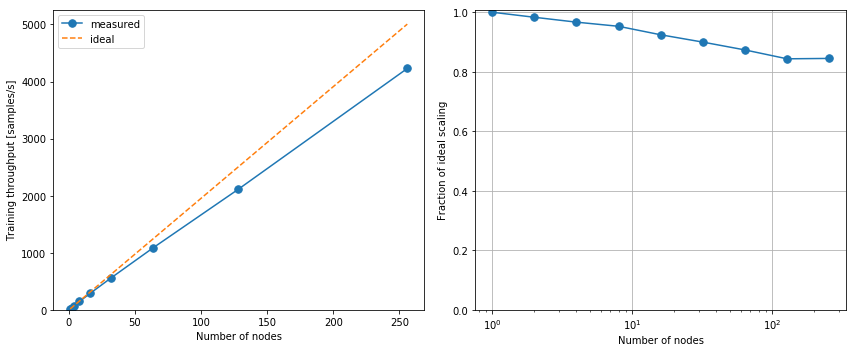

In [7]:
plot_scaling(ranks, rates, ideal_rates);

## DCGAN RPV scaling

In [8]:
cat ../configs/rpvgan.yaml

experiment_config:
    name: rpvgan
    output_dir: $SCRATCH/atlas_gan/RPV_GAN_000

data_config:
    name: rpv_images
    train_file: /global/cscratch1/sd/sfarrell/atlas_gan/data/RPV10_1400_850_01.npz
    n_train: 65536 #262144
    scale: 4.e+6

model_config:
    n_filters: 16
    noise_dim: 64
    optimizer: 'Adam'
    learning_rate: 0.0001
    label_flip_rate: 0.01

train_config:
    batch_size: 64
    n_epochs: 1


In [9]:
name = 'rpvgan'
log_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir)
             if f.startswith(name)]
ranks, rates, ideal_rates = parse_logs(log_files)

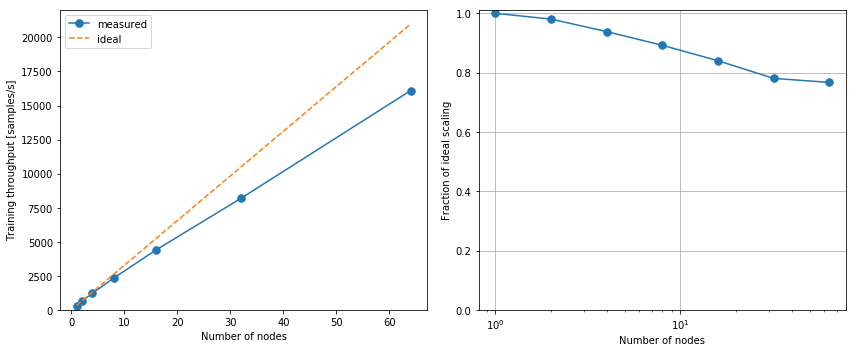

In [10]:
plot_scaling(ranks, rates, ideal_rates);